In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from lib import dpf, panda_baseline_models, panda_datasets, panda_baseline_training
from lib.utils import file_utils, torch_utils, misc_utils

print(torch.__version__, np.__version__)

1.3.1 1.16.4


In [3]:
# Experiment configuration
experiment_name = "baseline_vision_only"
dataset_args = {
    'use_proprioception': False,
    'use_vision': True,
    'vision_interval': 10,
}

In [4]:
# Create model & training buddy
model = panda_baseline_models.PandaBaselineModel(use_prev_state=True, units=32)
buddy = torch_utils.TrainingBuddy(experiment_name, model, log_dir="logs/baseline", checkpoint_dir="checkpoints/baseline")

Using device: cuda
No checkpoint found


In [5]:
# Load dataset
trainset = panda_datasets.PandaDynamicsDataset(
    "data/pull-test.hdf5",
    "data/push-test.hdf5",
    **dataset_args
)

Parsed data: 389533 active, 195332 inactive
Keeping: 194766


In [14]:
# trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
# for i in range(5):
#     print("Training epoch", i)
#     panda_baseline_training.train(buddy, model, trainset_loader, log_interval=100, state_noise_std=0.2)

# trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
# for i in range(5):
#     print("Training epoch", i)
#     panda_baseline_training.train(buddy, model, trainset_loader, log_interval=100, state_noise_std=0.1)

trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
for i in range(5):
    print("Training epoch", i)
    panda_baseline_training.train(buddy, model, trainset_loader, log_interval=100, state_noise_std=0.1)

Training epoch 0
................Saved checkpoint to path: checkpoints/baseline/baseline_vision_only-0000000000190000.ckpt
.......Epoch loss: 0.00856574
Training epoch 1
.......................Epoch loss: 0.00850498
Training epoch 2
.......................Epoch loss: 0.008533533
Training epoch 3
.......................Epoch loss: 0.008504716
Training epoch 4
......................Epoch loss: 0.008521559


# Model eval
### Training set

Progress: [####################] 100.0%


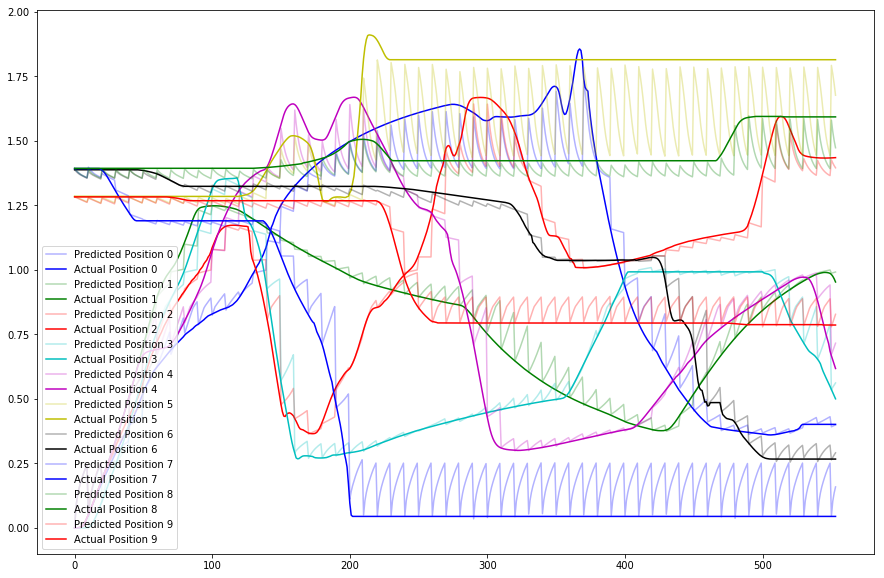

(10, 554, 1)
Position MSE:  0.009626254


In [15]:
eval_trajectories = panda_datasets.load_trajectories(
    ("data/pull-test.hdf5", 5),
    ("data/push-test.hdf5", 5),
    **dataset_args
)
pred, actual = panda_baseline_training.rollout(model, eval_trajectories)
panda_baseline_training.vis_rollout(pred, actual)

### Validation set

Progress: [####################] 100.0%


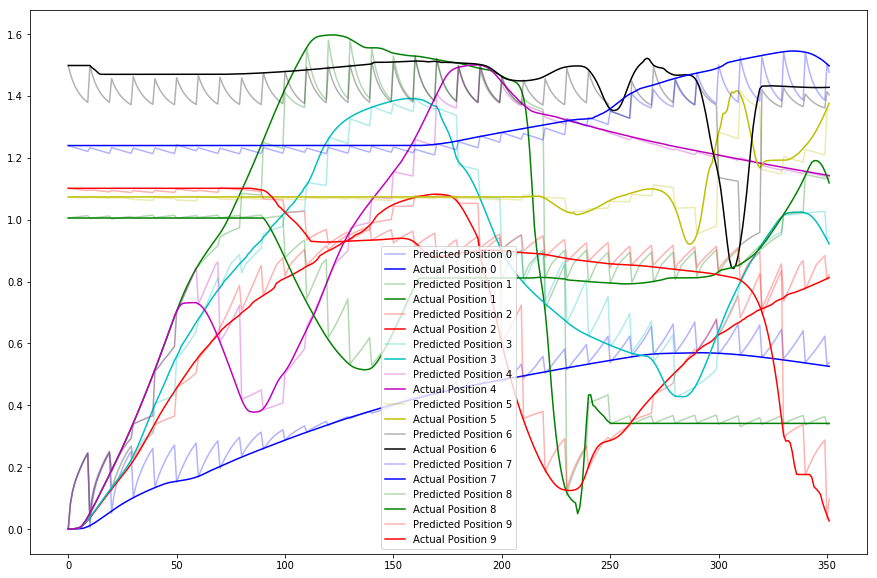

(10, 352, 1)
Position MSE:  0.0054092617


In [16]:
eval_trajectories = panda_datasets.load_trajectories(
    ("data/pull-test-small.hdf5", 5),
    ("data/push-test-small.hdf5", 5),
    **dataset_args
)
pred, actual = panda_baseline_training.rollout(model, eval_trajectories)
panda_baseline_training.vis_rollout(pred, actual)

In [17]:
buddy.save_checkpoint()

Saved checkpoint to path: checkpoints/baseline/baseline_vision_only-0000000000199797.ckpt
